# Software Defect Detection

> International Hellenic University <br />
> MSc Data Science <br />
> Machine Learning Concepts and Principles <br />
> Lazaros Panitsidis & Konstantinos Kravaritis <br />
> lpanitsidis@ihu.edu.gr & kkravaritis@ihu.edu.gr <br />
> <br />
> project in GitHub: <br />
> https://github.com/LazarosPan/Software-Defect-Detection

## Contents
1. [Python Libraries](#0)
1. [Data Preprocessing](#1)
1. [ML Models](#2)
1. [Results](#3)
1. [Performance Summary of Classifiers Across Datasets](#4)

<a id='0'></a>
## Python Libraries

In [42]:
# # Install Python libraries
# %pip install -U numpy
# %pip install -U pandas
# %pip install -U seaborn
# %pip install -U matplotlib
# %pip install -U scikit-learn
# %pip install -U imbalanced-learn

In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import statistics as stats # https://docs.python.org/3/library/statistics.html#statistics.fmean
#import scipy.stats as spstats
import matplotlib.pyplot as plt

### Validation & Normalization methods ###
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

### ML models ###
from sklearn.linear_model import LogisticRegression, SGDClassifier # C1 loss: log_loss => LogisticRegression with SGD
from sklearn.linear_model import Perceptron # C2
from sklearn.svm import SVC # C3
from sklearn.svm import LinearSVC # C4
from sklearn.tree import DecisionTreeClassifier # C5
from sklearn.ensemble import RandomForestClassifier # C6
from sklearn.neural_network import MLPClassifier # C7

### Metrics ###
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, make_scorer
from imblearn.metrics import geometric_mean_score # https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.geometric_mean_score.html
import time
import timeit # https://stackoverflow.com/questions/17579357/time-time-vs-timeit-timeit

### Pipeline ###
from sklearn.pipeline import make_pipeline , Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

### Custom Modules ###
from functions.data_types import optimize_dtypes
from functions.dataframe_actions import df_info, df_clean
from functions.ml_training import train_classifiers, train_classifiers_tuned, plot_metrics

### Other configurations ###
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
# #import warnings library
# import warnings
# # ignore all warnings
# warnings.filterwarnings('ignore')

<a id='2'></a>
## Data Preprocessing

### read the .csv files and make dataframes

In [44]:
# to read .csv files from another directory
data_location = "" # "/<path>"

jm1 = pd.read_csv(data_location + "jm1.csv")
mc1 = pd.read_csv(data_location + "mc1.csv")
pc3 = pd.read_csv(data_location + "pc3.csv")

### clean the dataframes from non-numeric data

In [45]:
# drop all rows that cointain non numeric valeus
jm1 = df_clean(jm1)
mc1 = df_clean(mc1)
pc3 = df_clean(pc3)

### extract useful information about the dataframes

In [46]:
dataframes = [jm1, mc1, pc3]
dataframe_names = ["jm1", "mc1", "pc3"]
df_info(dataframes, dataframe_names)

----- information for  jm1  -----
jm1  :  (10880, 22) (rows, columns)
jm1  :  0 missing values
jm1  :  1973 duplicate values
jm1  : Value counts for  defects
defects
False    8777
True     2103
Name: count, dtype: int64
----- information for  mc1  -----
mc1  :  (9466, 39) (rows, columns)
mc1  :  0 missing values
mc1  :  7450 duplicate values
mc1  : Value counts for  c
c
False    9398
True       68
Name: count, dtype: int64
----- information for  pc3  -----
pc3  :  (1563, 38) (rows, columns)
pc3  :  0 missing values
pc3  :  124 duplicate values
pc3  : Value counts for  c
c
False    1403
True      160
Name: count, dtype: int64


#### Label Encoding

* Use map instead of LabelEncoder() to ensure that False is 0 and True is 1 in all dataframes.
* With LabelEncoder() it depends on the order that the labels appear in the dataframe.

In [47]:
# class_le = LabelEncoder()
# jm1['defects'] = class_le.fit_transform(jm1['defects'].values)
# print("Classes of Label Encoder:", class_le.classes_)

In [48]:
# Map the "size" ordinal feature to an integer value
map_lexicon = {False: 0, True: 1}
jm1['defects'] = jm1['defects'].map(map_lexicon)
mc1['c'] = mc1['c'].map(map_lexicon)
pc3['c'] = pc3['c'].map(map_lexicon)

#### find optimal data types for faster computation

In [49]:
jm1 = optimize_dtypes(jm1)
mc1 = optimize_dtypes(mc1)
pc3 = optimize_dtypes(pc3)

In [50]:
print("---------- Optimal Data Types ----------")
print(jm1.dtypes)
print("---------- Optimal Data Types ----------")
print(mc1.dtypes)
print("---------- Optimal Data Types ----------")
print(pc3.dtypes)

---------- Optimal Data Types ----------
loc                  float16
v(g)                 float16
ev(g)                float16
iv(g)                float16
n                    float16
v                    float32
l                    float16
d                    float16
i                    float16
e                    float32
b                    float16
t                    float32
lOCode                uint16
lOComment             uint16
lOBlank               uint16
locCodeAndComment      uint8
uniq_Op              float16
uniq_Opnd            float16
total_Op             float16
total_Opnd           float16
branchCount          float16
defects                uint8
dtype: object
---------- Optimal Data Types ----------
LOC_BLANK                            uint8
BRANCH_COUNT                        uint16
CALL_PAIRS                           uint8
LOC_CODE_AND_COMMENT                 uint8
LOC_COMMENTS                         uint8
CONDITION_COUNT                     uint16
CYCLOMAT

#### Define Feature variables (inputs or predictors) and Target variables

In [51]:
jm1_y = jm1.defects
jm1_x = jm1.drop('defects',axis = 1 )

mc1_y = mc1.c
mc1_x = mc1.drop('c',axis = 1 )

pc3_y = pc3.c
pc3_x = pc3.drop('c',axis = 1 )

<a id='3'></a>
## ML Models

#### define the classifiers

In [52]:
# ## very bad scores in jm1 and in general for perceptron and svc
# np.random.MT19937(seed=13) # https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html

# lr = LogisticRegression(solver= 'saga', penalty='elasticnet',l1_ratio=0.5, dual=False, max_iter=1000, n_jobs=-1) # 'l2' & 'newton-cholesky'
# perc = Perceptron(penalty='elasticnet', l1_ratio=0.5, class_weight='balanced', max_iter=1000, n_jobs=-1)
# #linear_svm = SVC(kernel='linear', cache_size=4000) # training doesnt end
# linear_svm = LinearSVC(penalty='l2',dual=False, class_weight='balanced', max_iter=1000)
# rbf_svm = SVC(kernel='rbf', gamma='scale', cache_size=4000, class_weight='balanced', max_iter=1000)
# tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split= 3, min_samples_leaf=2, class_weight='balanced', ccp_alpha=0.01) # 'gini is faster, 'entrtopy' usually gives slightly better results # https://quantdare.com/decision-trees-gini-vs-entropy/
# rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=None, min_samples_split=3, min_samples_leaf=2, class_weight='balanced', ccp_alpha=0.01,n_jobs=-1)
# mlp = MLPClassifier(hidden_layer_sizes=(20,10), solver='adam', learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000)

# classifiers = [lr, perc, linear_svm, rbf_svm, tree, rf, mlp]

In [53]:
# np.random.MT19937(seed=13) # https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html

# lr = LogisticRegression(solver= 'newton-cholesky', penalty='l2', max_iter=1000, n_jobs=-1) # 'l2' & 'newton-cholesky'
# perc = Perceptron(penalty='elasticnet', l1_ratio=0.1, class_weight='balanced', max_iter=1000, n_jobs=-1)
# #linear_svm = SVC(kernel='linear', cache_size=4000) # training doesnt end
# linear_svm = LinearSVC(penalty='l2',dual=False, class_weight='balanced', max_iter=1000)
# rbf_svm = SVC(kernel='rbf', gamma='scale', cache_size=4000, class_weight='balanced', max_iter=1000)
# tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split= 3, min_samples_leaf=2, class_weight='balanced', ccp_alpha=0.01) # 'gini is faster, 'entrtopy' usually gives slightly better results # https://quantdare.com/decision-trees-gini-vs-entropy/
# rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=None, min_samples_split=3, min_samples_leaf=2, class_weight='balanced', ccp_alpha=0.01,n_jobs=-1)
# mlp = MLPClassifier(hidden_layer_sizes=(20,10), solver='adam', learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000)

# classifiers = [lr, perc, linear_svm, rbf_svm, tree, rf, mlp]

In [54]:
np.random.MT19937(seed=13) # https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html

lr = LogisticRegression(solver='liblinear',max_iter=1000) # https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions
perc = Perceptron(penalty='l2', eta0=0.05, max_iter=1000, early_stopping=True, tol=0.01, n_iter_no_change=10, n_jobs=-1)
#linear_svm = SVC(kernel='linear', cache_size=30000) # training doesnt end
linear_svm = LinearSVC(dual=False,max_iter = 1000)
rbf_svm = SVC(kernel='rbf', cache_size=2000)
tree = DecisionTreeClassifier(criterion='entropy',max_depth=5)
rf = RandomForestClassifier(criterion='entropy',max_depth=5, n_jobs=-1)
mlp = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000, early_stopping=True, tol=0.0001, n_iter_no_change=10)

classifiers = [lr, perc, linear_svm, rbf_svm, tree, rf, mlp]

#### define the metrics
* **Usefull paper about metrics on imbalanced datasets :** 
    - [Predictive Accuracy: A Misleading Performance Measure for Highly
Imbalanced Data ](https://support.sas.com/resources/papers/proceedings17/0942-2017.pdf)

In [55]:
# Define multiple metrics
scoring = {'Accuracy': make_scorer(accuracy_score),
           'F1-score': make_scorer(f1_score, average='weighted'),
           'G-Mean score': make_scorer(geometric_mean_score, average='weighted')
          }

#### define the normalization methods

In [56]:
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()

## If we use MinMaxScaler or StandardScaler, the feature names will be lost, so we do it mannually.

# x_scaled = (x - x.min(axis=0)) / (x.max(axis=0)-x.min(axis=0))
# x_scaled = (x - x.mean())/x.std()

#### define Cross Validation's folds method

In [57]:
#rng = np.random.RandomState(13) # random number generator , use it in every random state if shuffle=True for different results.Usefull to test a specific algorithm multiple times within a for loop.
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
#search_cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=None) # for nested cross validation in order tune the hyperparameters automatically

### N1: No Normalization

#### jm1

In [58]:
jm1_nn_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring)

In [59]:
# convert to dataframe for easier visualization (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html)
df_jm1_nn_results = pd.DataFrame.from_dict(jm1_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_nn_results['Normalization method'] = 'No normalization'
#df_jm1_nn_results

#### mc1

In [60]:
mc1_nn_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring)

In [61]:
# convert to dataframe for easier visualization
df_mc1_nn_results = pd.DataFrame.from_dict(mc1_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_nn_results['Normalization method'] = 'No normalization'
#df_mc1_nn_results

#### pc3

In [62]:
pc3_nn_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring)

In [63]:
# convert to dataframe for easier visualization
df_pc3_nn_results = pd.DataFrame.from_dict(pc3_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_nn_results['Normalization method'] = 'No normalization'
#df_pc3_nn_results

### N2: Min-Max Normalization

#### jm1

In [64]:
jm1_mmn_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring, min_max_scaler)

In [65]:
# convert to dataframe for easier visualization
df_jm1_mmn_results = pd.DataFrame.from_dict(jm1_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_jm1_mmn_results

#### mc1

In [66]:
mc1_mmn_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring, min_max_scaler)

In [67]:
# convert to dataframe for easier visualization
df_mc1_mmn_results = pd.DataFrame.from_dict(mc1_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_mc1_mmn_results

#### pc3

In [68]:
pc3_mmn_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring, min_max_scaler)

In [69]:
# convert to dataframe for easier visualization
df_pc3_mmn_results = pd.DataFrame.from_dict(pc3_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_pc3_mmn_results

### N3: Feature Standardization

#### jm1

In [70]:
jm1_fs_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring, std_scaler)

In [71]:
# convert to dataframe for easier visualization
df_jm1_fs_results = pd.DataFrame.from_dict(jm1_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_fs_results['Normalization method'] = 'Standardization'
#df_jm1_fs_results

#### mc1

In [72]:
mc1_fs_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring, std_scaler)

In [73]:
# convert to dataframe for easier visualization
df_mc1_fs_results = pd.DataFrame.from_dict(mc1_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_fs_results['Normalization method'] = 'Standardization'
#df_mc1_fs_results

#### pc3

In [74]:
pc3_fs_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring, std_scaler)

In [75]:
# convert to dataframe for easier visualization
df_pc3_fs_results = pd.DataFrame.from_dict(pc3_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_fs_results['Normalization method'] = 'Standardization'
#df_pc3_fs_results

In [76]:
# ## example without using train_classifiers function

# lr_fs_pipe = Pipeline([('std_scaler', StandardScaler()), ('lr', LogisticRegression())])

# jm1_lr_fs_scores = cross_validate(lr_fs_pipe, jm1_x, jm1_y,
#                         cv=cv, scoring=scoring,
#                         n_jobs=None, return_train_score=False)

# jm1_lr_fs_accuracy = stats.fmean(jm1_lr_fs_scores['test_Accuracy'])
# jm1_lr_fs_f1 = stats.fmean(jm1_lr_fs_scores['test_F1-score'])
# jm1_lr_fs_g_mean = stats.fmean(jm1_lr_fs_scores['test_G-Mean score'])
# jm1_lr_fs_fit_time = sum(jm1_lr_fs_scores['fit_time'])

<a id='4'></a>
## Results

### jm1 dataset

In [77]:
jm1_results = pd.concat([df_jm1_nn_results, df_jm1_mmn_results, df_jm1_fs_results])
jm1_results= jm1_results.round(3)
jm1_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.807,0.752,0.469,6.534,No normalization
1,Perceptron,0.682,0.623,0.428,0.232,No normalization
2,LinearSVC,0.809,0.749,0.459,5.251,No normalization
3,SVC,0.807,0.725,0.405,17.155,No normalization
4,DecisionTreeClassifier,0.804,0.758,0.489,0.246,No normalization
5,RandomForestClassifier,0.808,0.747,0.455,3.691,No normalization
6,MLPClassifier,0.802,0.729,0.417,2.260,No normalization
0,LogisticRegression,0.809,0.744,0.446,0.348,Min-Max normalization
1,Perceptron,0.804,0.744,0.452,0.309,Min-Max normalization
2,LinearSVC,0.809,0.745,0.449,0.969,Min-Max normalization


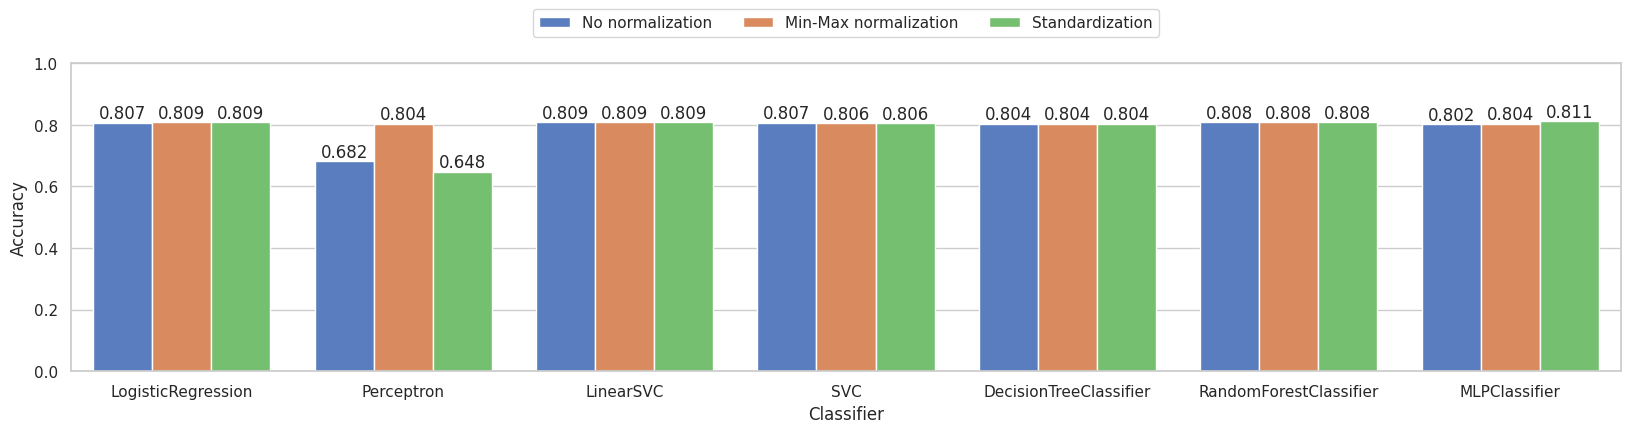

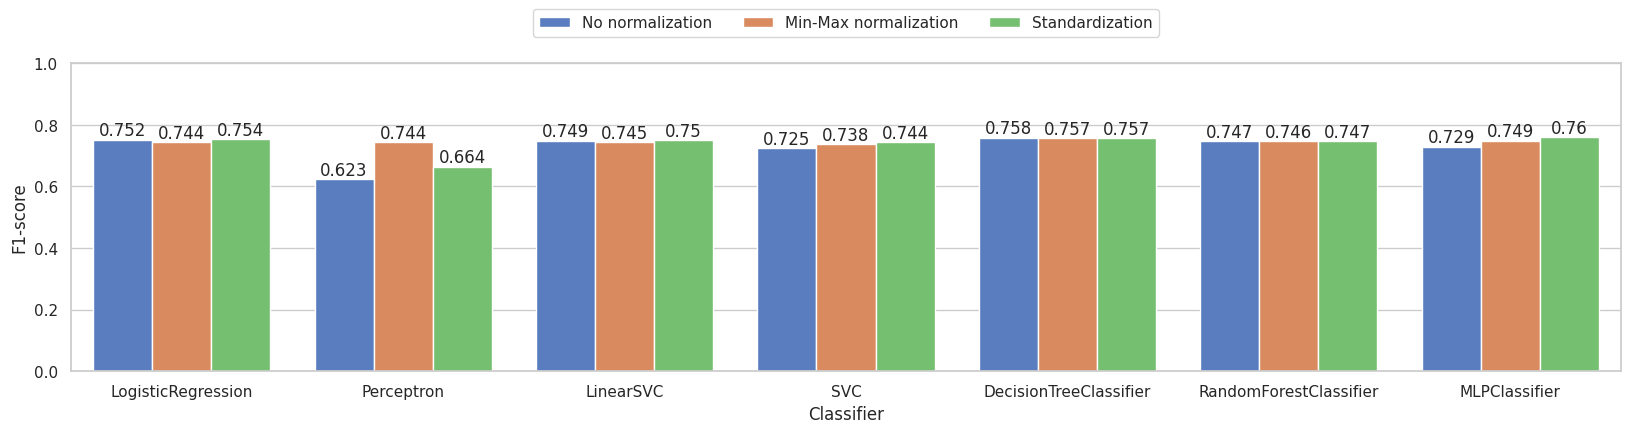

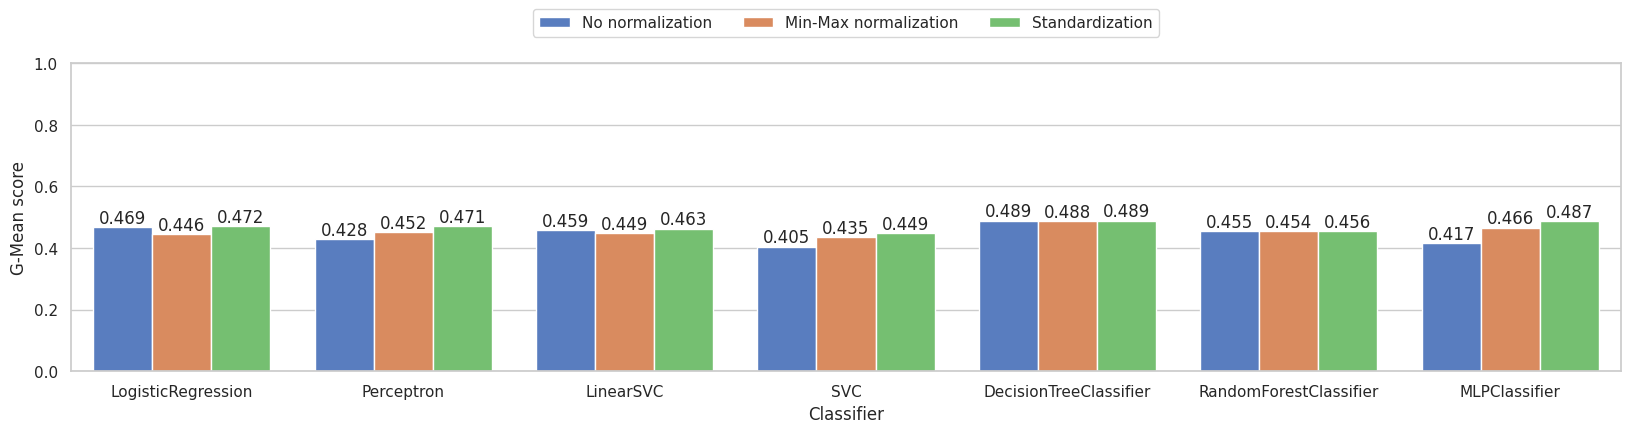

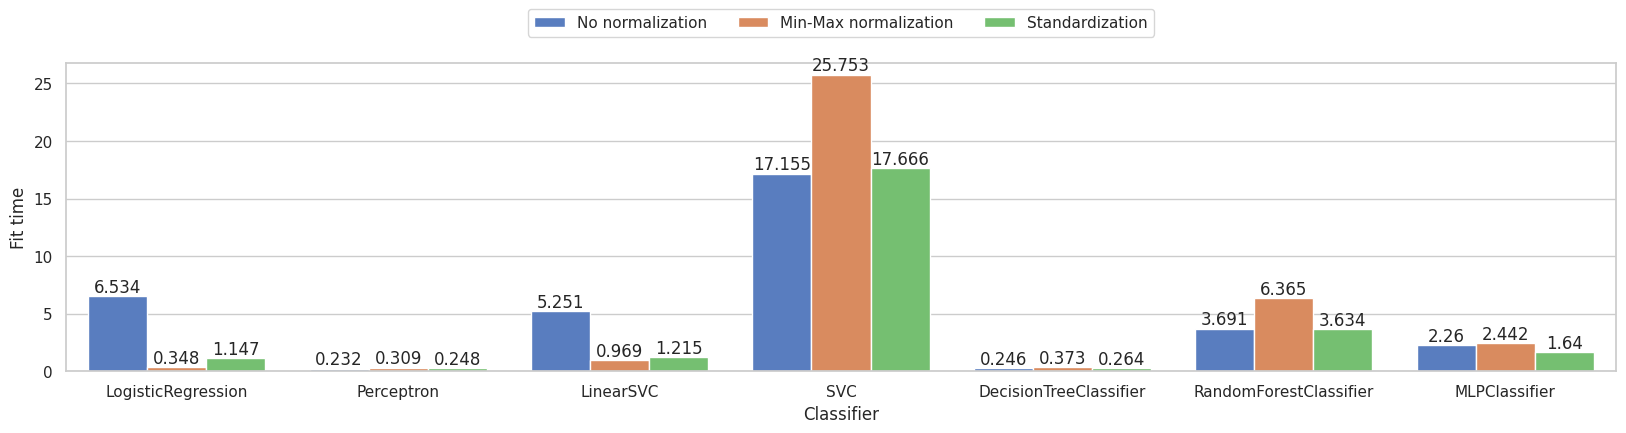

In [78]:
plot_metrics(jm1_results)

#### Performance Evaluation of Classifiers on JM1 Dataset

##### Accuracy
- **Most classifiers except Perceptron**  consistently show good accuracy across all normalization methods, indicating stable performance.
- **Perceptron** exhibits noticeable variability in accuracy, suggesting sensitivity to data preprocessing steps.

##### F1-Score
- **Most classifiers** do better with **Standardization**, but not a significant improvement though.
- The **Perceptron** improves in F1-score with **Min-Max normalization**, significant given its lower score without normalization.

##### G-Mean Score
- G-Mean scores are moderate across classifiers, suggesting **none of them can handle class imbalance**.
- Normalization methods do not significantly impact G-Mean scores, implying class balance management is not highly dependent on data scaling. **Standardization** though, seems to improve the results slighly.

##### Fit Time
- **SVC** generally has longer training times, especially with **normalization methods**, likely due to model complexity.
- **Perceptron and Decision Tree** have significantly lower training times than the rest of the algorithms.
- **Logistic Regression, Linear SVC and Random Forest** have longer fit times while trained without any **normalization method**.
- **MLP and Random Forest** show a balance in fit time, neither the quickest nor the slowest, suggesting moderate computational efficiency.

### mc1 dataset

In [79]:
mc1_results = pd.concat([df_mc1_nn_results, df_mc1_mmn_results, df_mc1_fs_results])
mc1_results = mc1_results.round(3)
mc1_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.993,0.991,0.343,18.235,No normalization
1,Perceptron,0.991,0.988,0.084,0.283,No normalization
2,LinearSVC,0.993,0.989,0.084,7.918,No normalization
3,SVC,0.993,0.989,0.084,1.026,No normalization
4,DecisionTreeClassifier,0.994,0.993,0.565,0.162,No normalization
5,RandomForestClassifier,0.994,0.993,0.498,2.895,No normalization
6,MLPClassifier,0.993,0.989,0.084,1.552,No normalization
0,LogisticRegression,0.993,0.989,0.125,0.623,Min-Max normalization
1,Perceptron,0.992,0.989,0.084,0.226,Min-Max normalization
2,LinearSVC,0.993,0.989,0.125,0.267,Min-Max normalization


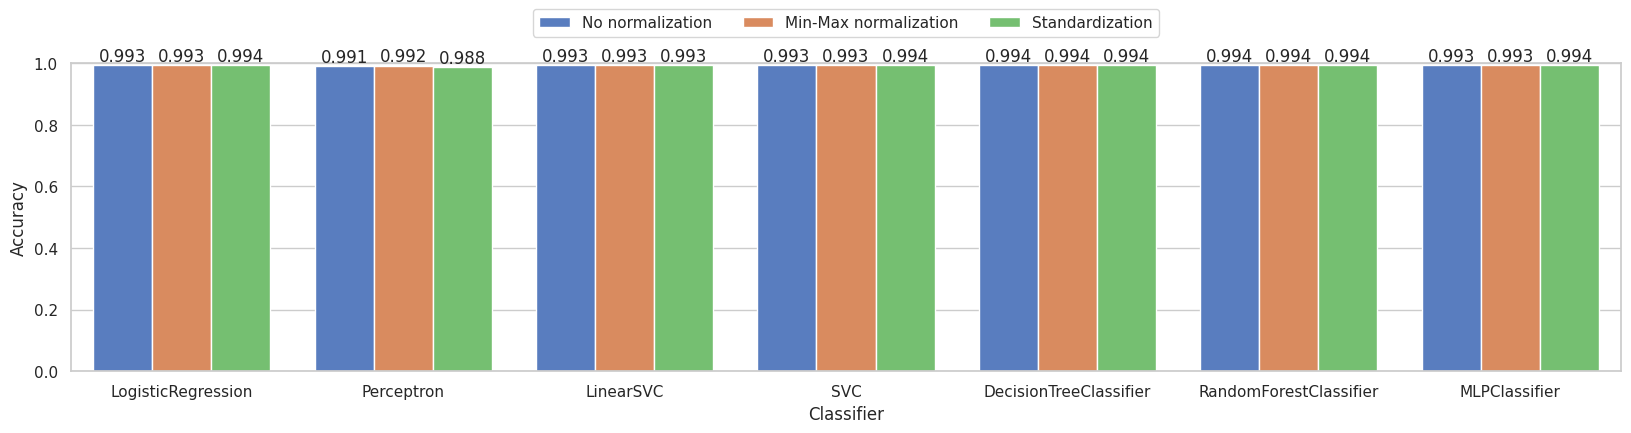

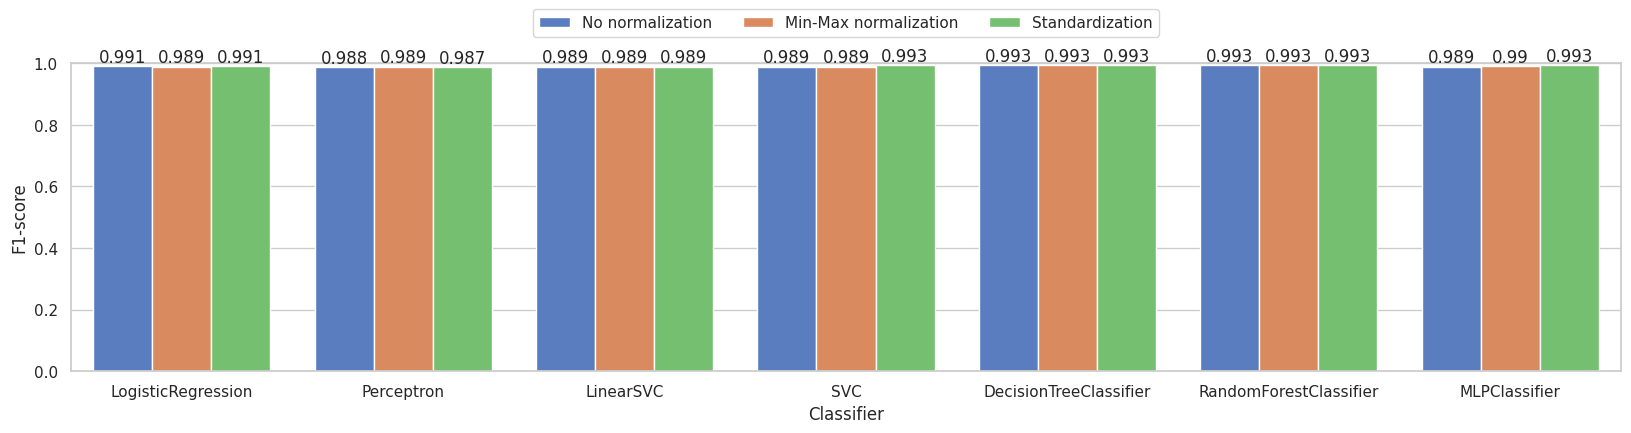

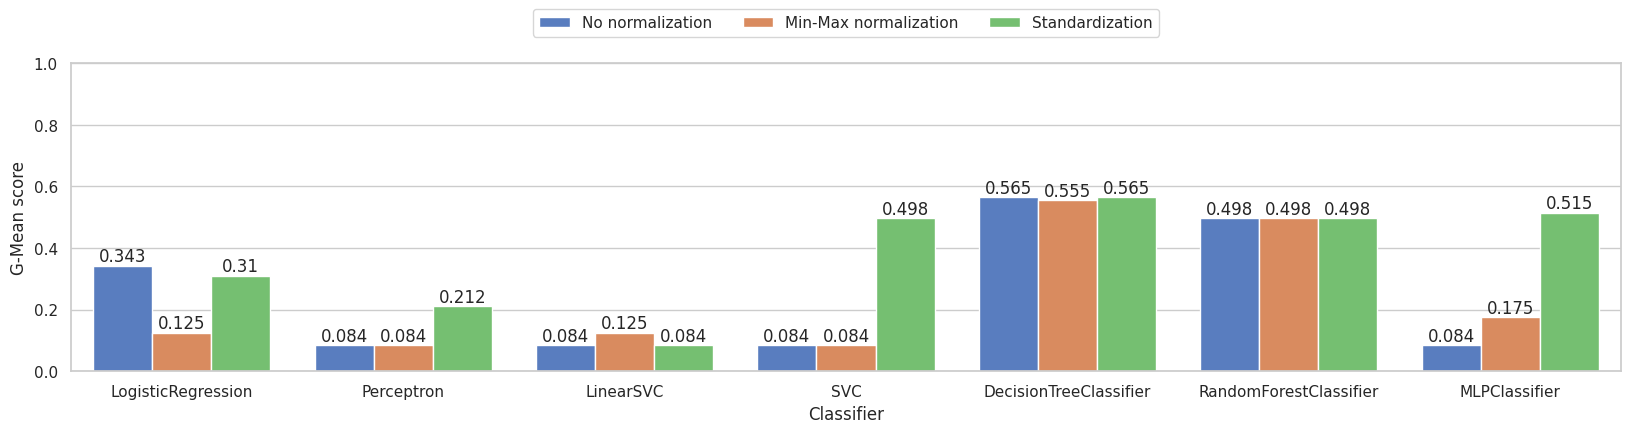

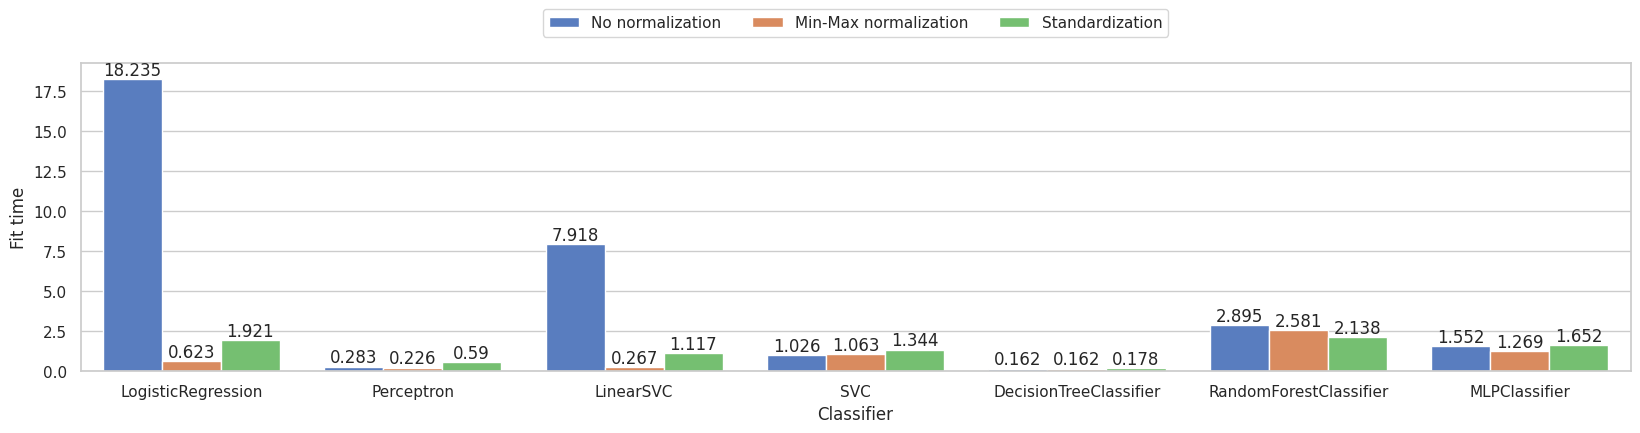

In [80]:
plot_metrics(mc1_results)

#### Performance Evaluation of Classifiers on MC1 Dataset

##### Accuracy
- **All classifiers** exhibit exceptionally **high accuracy despite the normalization method**, with most achieving above **0.993**. This suggests that the models are well-tuned to the dataset and the dataset probably lacks complexity (if we consider the performance on the other datasets).

##### F1-Score
- Similar to accuracy, F1-scores are also remarkably **high across all classifiers**, indicating a strong balance between precision and recall. Again, there are **no significant differences between normalization methods**.

##### G-Mean Score
- Despite high accuracy and F1-scores, G-Mean scores vary significantly among classifiers, with the **Decision Tree** showing the highest score, which implies better performance on the imbalanced classes.
- The low G-Mean scores for some classifiers like the **Perceptron** and **SVC** with **no normalization and Min-Max normalization** suggest that they **can not handle class imbalance** as effectively.

##### Fit Time
- The **Logistic Regression** has a notably longer fit time without normalization but is more efficient with **Min-Max normalization** and **Standardization**.
- **Linear SVC** experiences a significant reduction in fit time with **Min-Max normalization** and **Standardization**, indicating this preprocessing step can greatly influence the efficiency of this model.
- **Decision Tree** consistently shows quick fit times, making it an efficient choice for relatively big datasets.

### pc3 dataset

In [81]:
pc3_results = pd.concat([df_pc3_nn_results, df_pc3_mmn_results, df_pc3_fs_results])
pc3_results = pc3_results.round(3)
pc3_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.900,0.877,0.485,0.579,No normalization
1,Perceptron,0.698,0.723,0.326,0.159,No normalization
2,LinearSVC,0.901,0.875,0.464,0.254,No normalization
3,SVC,0.898,0.849,0.303,0.128,No normalization
4,DecisionTreeClassifier,0.889,0.860,0.410,0.096,No normalization
5,RandomForestClassifier,0.896,0.849,0.303,2.379,No normalization
6,MLPClassifier,0.889,0.847,0.315,0.465,No normalization
0,LogisticRegression,0.897,0.856,0.346,0.072,Min-Max normalization
1,Perceptron,0.894,0.851,0.329,0.109,Min-Max normalization
2,LinearSVC,0.897,0.856,0.346,0.091,Min-Max normalization


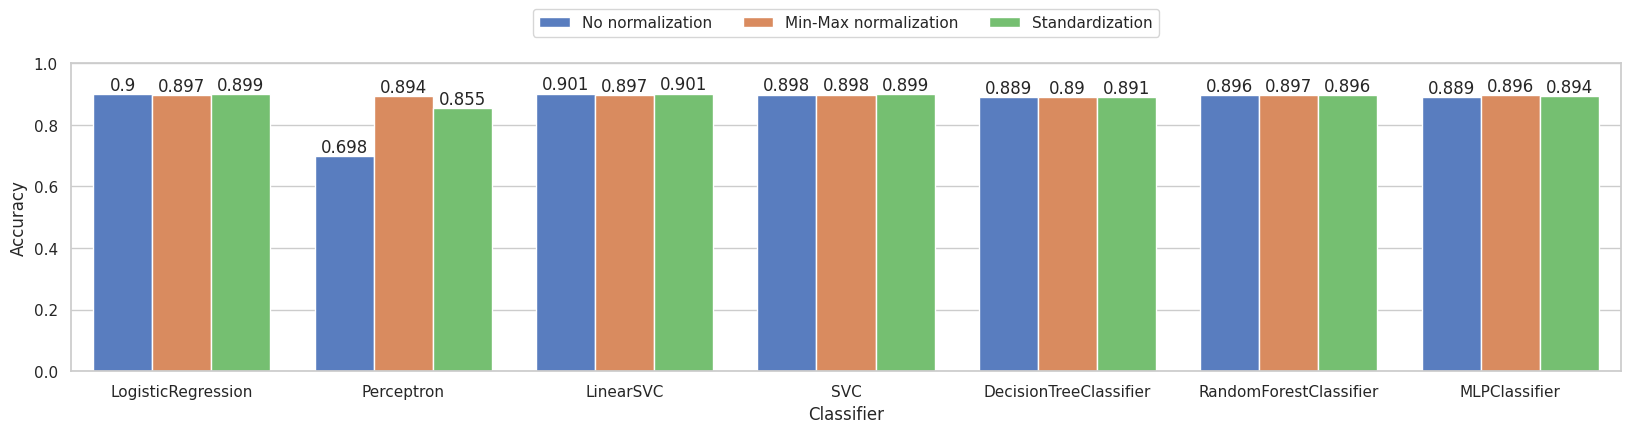

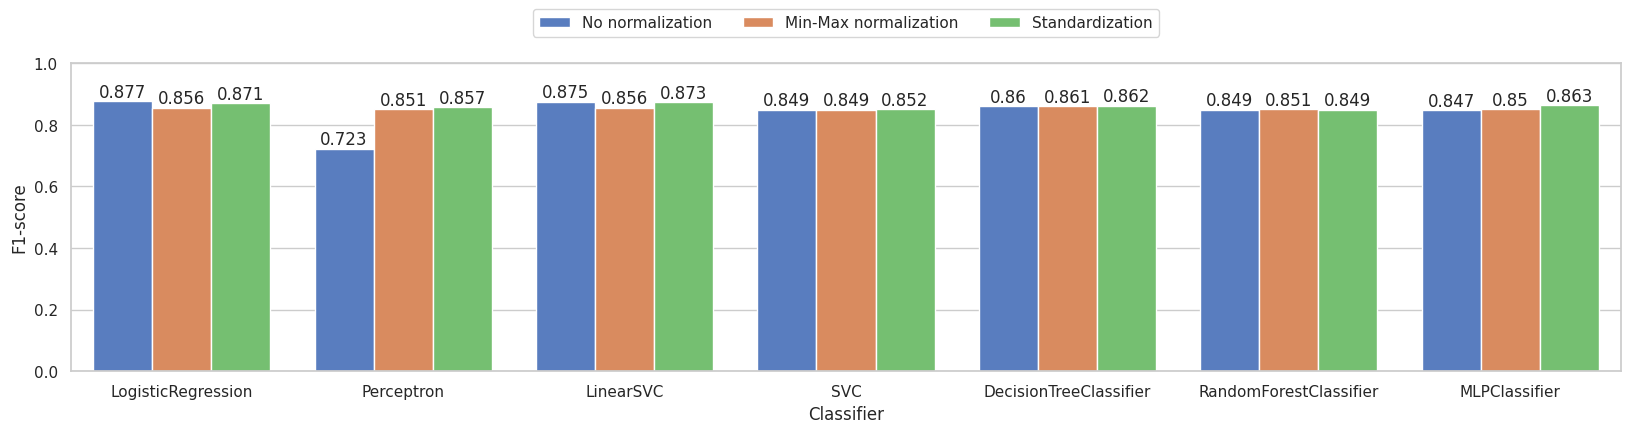

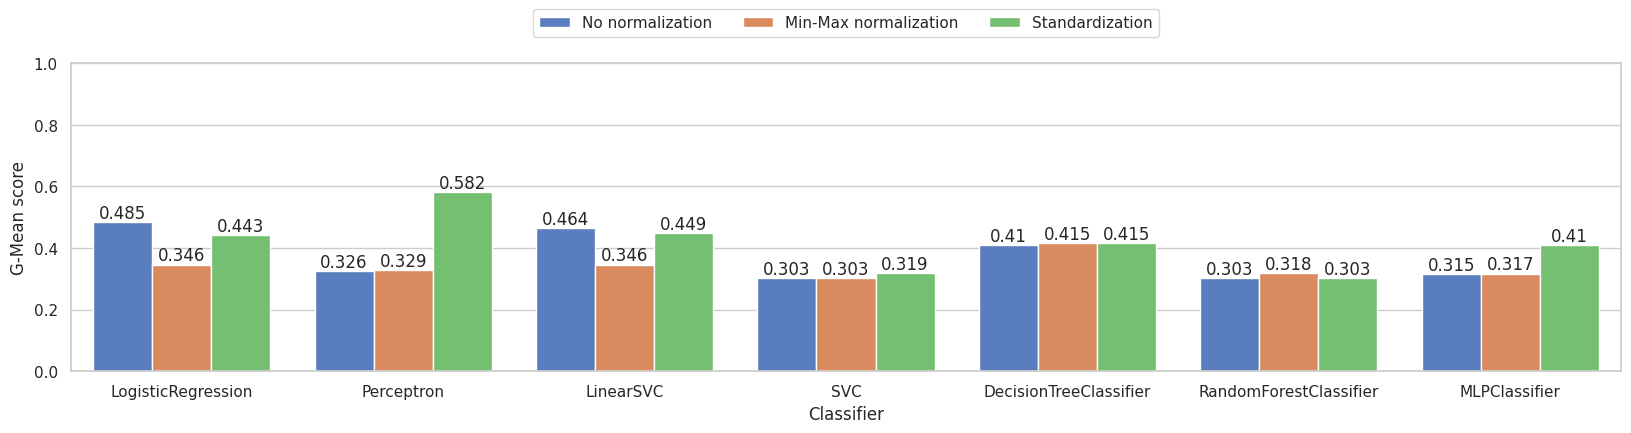

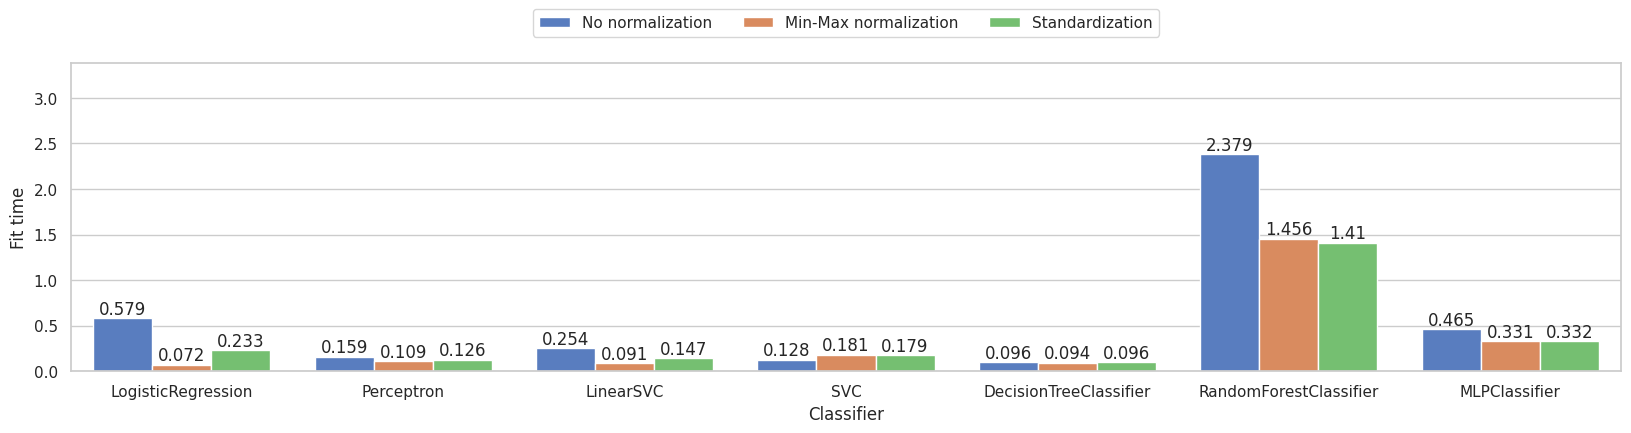

In [82]:
plot_metrics(pc3_results)

#### Performance Evaluation of Classifiers on PC3 Dataset

##### Accuracy:
- **Most classifiers except Perceptron** demonstrate high accuracy across all normalization methods. Their performance is consistent, with **Linear SVC** slightly outperforming in the non-normalized and standardized scenarios.
- The **Perceptron** shows the largest improvement in accuracy when moving from no normalization to **Min-Max normalization**, suggesting it benefits significantly from feature scaling.

##### F1-Score:
- The F1-scores are generally high for all classifiers, indicating a good balance of precision and recall. **Most classifiers** maintains a high F1-score across different normalization methods, while **Perceptron** sees a substantial increase with **Min-Max normalization** and **Standardization**.

##### G-Mean Score:
- **G-Mean scores** suggest some variability in the classifiers' ability to handle class balance. Overall, classifiers have **poor performance when considering class imbalance**.
- **Logistic Regression** and **Linear SVC** perform worse with **Min-Max normalization**, while **Perceptron** and **MLP** improve their performance with **Standardization**.
- **SVC, Decision Tree and Random Forest** have almost the same performance across the different **normalization methods**.

##### Fit Time:
- **Logistic Regression and Random Forest** have the most notable decrease in fit time with **both normalization methods**, suggesting that scaling can have a considerable effect on the computational efficiency of certain models.
- **MLP** once again increased its training time when trained after **Standardization**, while decreases it when trained after **Min-Max normalization**. 

<a id='5'></a>
## Performance Summary of Classifiers Across Datasets

##### Accuracy
- Classifiers like **Logistic Regression** and **Linear SVC** demonstrate high and stable accuracy across all datasets and normalization methods.
- **Perceptron** shows notable improvement in accuracy with **Min-Max normalization** across datasets, indicating its sensitivity to feature scaling.

##### F1-Score
- High F1-scores are consistently observed across all classifiers, suggesting a robust balance between precision and recall. The **Perceptron** benefits from **Min-Max normalization** and **Standardization**.

##### G-Mean Score
- To begin with, **all datasets are higly imbalanced**. While most classifiers do well in Accuracy and F1-Score, the **G-Mean score shows that all of them have medium to bad performance when taking into account the class imbalance**.
- The G-Mean scores vary among classifiers, with some, like the **Decision Tree**, performing a bit better on imbalanced classes. 
- **Min-Max normalization** does not significantly impact G-Mean scores for most classifiers, but **Standardization** slightly improves the G-Mean scores across datasets.

##### Fit Time
- Classifiers like **Perceptron** and **Decision Tree** are observed to have lower training times, indicating efficiency.
- **Random Forest** and **Logistic Regression** show decreased fit times with normalization methods, suggesting that scaling can optimize computational efficiency for these models.
- **MLP** shows a peculiar trend in training duration, with an increased fit time under **Standardization** possibly due to the unbounded nature of the data affecting the stability and rate of convergence. Conversely, fit time decreases with **Min-Max normalization**, likely because the bounded and uniform scale of input features facilitates a smoother and faster gradient descent process.